# Titanic

Se adjunta un dataset sobre el desastre del Titanic para hacer ejercicios libres.

Algunos ejercicios que puedes llegar a realizar son:

* Ver el número de valores nulos
* Representar el porcentaje de filas con atributos nulos.
* Limpieza de columnas.
* Saber la edad mínima y máxima de las personas del barco.
* Conocer la mediana de las edades.
* Ver los precios (columna `fares`) más altos y bajos.
* Número de pasajeros embarcados (columna `Embarked`).
* Ver la distribución de sexos en las personas embarcadas.

##### VARIABLES
<table>
  <tr>
    <th>Nombre de la columna</th>
    <th>Descripción</th>
  </tr>
  <tr>
    <td>PassengerId</td>
    <td>Identificador del pasajero. Único por cada pasajero.</td>
  </tr>
  <tr>
    <td>Survived</td>
    <td>Indica 1 si el pasajero sobrevivió al naufragio, 0 si no sobrevivió.</td>
  </tr>
  <tr>
    <td>Pclass</td>
    <td>Clase a la que pertenecía el pasajero: 1, 2 o 3.</td>
  </tr>
  <tr>
    <td>Name</td>
    <td>Nombre del pasajero.</td>
  </tr>
  <tr>
    <td>Sex</td>
    <td>Sexo biológico del pasajero.</td>
  </tr>
  <tr>
    <td>Age</td>
    <td>Edad del pasajero.</td>
  </tr>
  <tr>
    <td>SibSp</td>
    <td>Número de hermanos, hermanas, hermanastros o hermanastras en el barco.</td>
  </tr>
  <tr>
    <td>Parch</td>
    <td> Número de padres e hijos en el barco. </td>
  </tr>
  <tr>
    <td>Ticket</td>
    <td>Identificador del billete.</td>
  </tr>
  <tr>
    <td>Fare</td>
    <td>Precio pagado por el billete.</td>
  </tr>
    <tr>
    <td>Cabin</td>
    <td>Identificador del camarote asignado al pasajero.</td>
  </tr>
  <tr>
    <td>Embarked</td>
    <td>Puerto en el que embarcó el pasajero.</td>
  </tr>
</table>


In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

In [134]:
#Importamos los datos y vemos su estructura general
datos = pd.read_csv(r'C:\Users\danyr\Documents\GitHub\Titanic\titanic.csv')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [135]:
# Número de valores nulos.
# La cantidad de valores nulos presentes en Cabin no vale la pena corregirlos porque la imputación no sería nada representativa.
datos.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [159]:
# Porcentaje de filas con valores nulos.
filas = len(datos) #Número total de filas
filas_null = datos.isnull().any(axis=1).sum() # Número de filas con valores nulos
filas_sin_null = filas - filas_null #Numero de filas sin valores nulos

porcentajes = pd.DataFrame({'Tipo': ['Con valores nulos', 'Sin valores nulos'],
                               'Cantidad': [filas_null, filas_sin_null]}) # dataframe con las cantidades de filas con nulos y sin nulos.

#Representación gráfica
fig1 = px.pie(porcentajes, names='Tipo', values='Cantidad', title='Porcentaje de filas con NaN Original',
             width= 600,
             color_discrete_sequence=px.colors.sequential.Blues_r)

fig1.show()


### Limpieza de datos:

In [137]:
#Creamos una copia del dataframe datos, para poder modificarlo sin afectar al original.
df = datos.copy() 

# Creación de una columna nueva para el apellido.
df['LastName'] = df['Name'].apply(lambda x : x.split(',')[0])

In [138]:
#Eliminamos los decimales de la columna 'Age' 
df['Age'] = df['Age']//1
df[df['Age']<1]['Age']

78     0.0
305    0.0
469    0.0
644    0.0
755    0.0
803    0.0
831    0.0
Name: Age, dtype: float64

#### Vamos a tratar los valores nulos en 'Age' con el método de KNN:

In [139]:
#Se estandariza la columna 'Fare' para que no tenga un impacto desproporcionado en la distancia 
scaler = StandardScaler()
df['Fare'] = scaler.fit_transform(df[['Fare']])

In [140]:
#Se especifican las columnas que se usarán como predictores y se transforman en un array numérico de códigos one-hot
columnas=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',"Age"] 
encoder = OneHotEncoder(drop='first', sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df[columnas]))
df_encoded.columns = encoder.get_feature_names_out(columnas)

In [141]:
# Creamos dos dataframes basados en la presencia de Age
df_encoded['Age'] = df['Age']
df_with_age = df_encoded.dropna(subset=['Age']) #Sin los valores nulos
df_without_age = df_encoded[df_encoded['Age'].isna()].drop(columns='Age')

# Dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X = df_with_age.drop(columns='Age')
y = df_with_age['Age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)

scores = [207.94782609 125.07894737 212.78070175 131.16666667 169.02631579]
scores = [141.87826087  90.46929825 149.56578947  95.5877193  120.97587719]
scores = [126.59323671  66.33528265 140.74269006 110.4668616  115.41617934]
scores = [119.54184783  74.23903509 124.0120614  103.54824561 133.14144737]
scores = [123.23826087  75.04315789 127.36421053 125.93824561 133.79754386]
scores = [128.44516908  78.95614035 130.40618908 127.14961014 145.01461988]


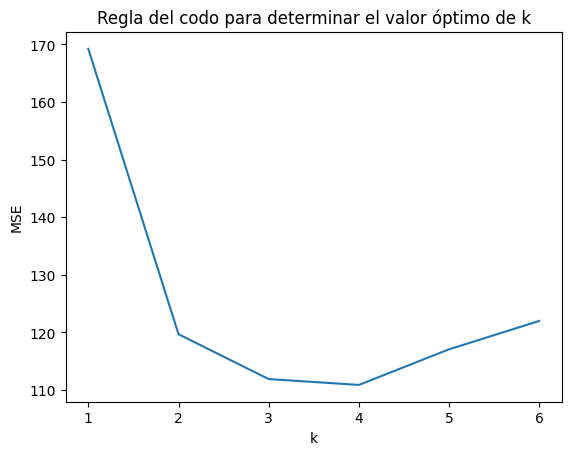

In [142]:
# Lista para almacenar los valores de MSE (Error Cuadrático Medio)
mse = []

# Rango de k para probar
k_range = range(1, 7)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Realizamos la validación cruzada para obtener una medida más robusta del error
    """  estamos tomando el negativo de los valores devueltos para obtener el MSE real. 
         Luego, añadimos la media de estos valores a nuestra lista de MSE para cada valor de k (mse.append(scores.mean())).
    """
    scores = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse.append(scores.mean())
    print(f'scores = {scores}')
    
 
# Graficamos los valores 
plt.plot(k_range, mse)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Regla del codo para determinar el valor óptimo de k')
plt.show()

In [143]:
#Definimos el mejor k:
best_k = k_range[mse.index(min(mse))]

# Creamos el modelo KNN con el mejor valor de k
knn = KNeighborsRegressor(n_neighbors= best_k)

# Ajustamos el modelo a los datos sin valores nulos
knn.fit(X_train, y_train)

# Imputamos los valores faltantes en la columna 'Age'
imputed_ages = knn.predict(df_without_age)
df.loc[df['Age'].isna(), 'Age'] = imputed_ages

* Saber la edad mínima y máxima de las personas del barco.


In [144]:
#Original
minAge_o= round(datos['Age'].min())
maxAge_o = datos['Age'].max()
print(f'La edad mínima es: {minAge_o} \nLa edad máxima es: {maxAge_o}')

La edad mínima es: 0 
La edad máxima es: 80.0


In [145]:
#Después de la imputación
minAge = round(df['Age'].min())
maxAge = df['Age'].max()
print(f'La edad mínima es: {minAge} \nLa edad máxima es: {maxAge}')

La edad mínima es: 0 
La edad máxima es: 80.0


* Conocer la mediana de las edades.


La mediana de la edad con los valores nulos sin corregir:  28.0
La mediana de la edad con valores nulos corregidos:  29.0


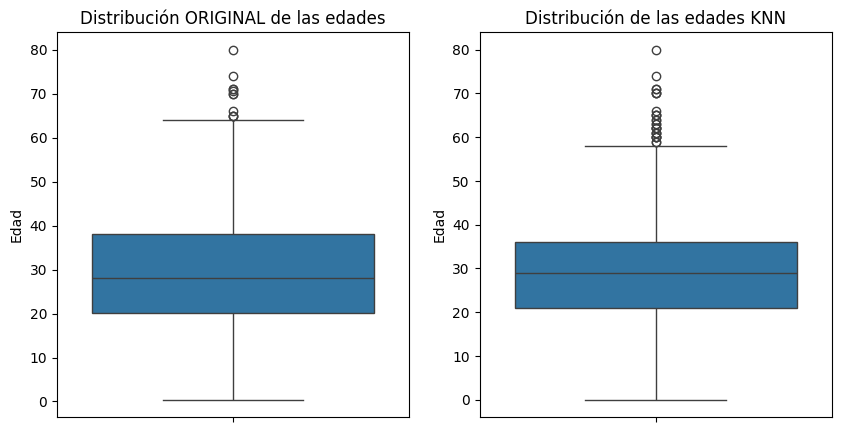

In [146]:
print('La mediana de la edad con los valores nulos sin corregir: ', datos['Age'].median())
print('La mediana de la edad con valores nulos corregidos: ',df['Age'].median())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=datos, y='Age', ax=axs[0])
axs[0].set_title('Distribución ORIGINAL de las edades')
axs[0].set_ylabel('Edad')

sns.boxplot(data=df, y='Age', ax=axs[1])
axs[1].set_title('Distribución de las edades KNN')
axs[1].set_ylabel('Edad');

* Porcentaje de filas con valores nulos después de corregir los NaN en 'Age'

In [147]:
# Porcentaje de filas con valores nulos.
filas2 = len(df)
filas_null2 = df.isnull().any(axis=1).sum()
filas_sin_null2 = filas - filas_null

porcentajes2 = pd.DataFrame({'Tipo': ['Filas con valores nulos', 'Filas sin valores nulos'],
                               'Cantidad': [filas_null2, filas_sin_null2]}) 


fig2 = px.pie(porcentajes2, names='Tipo', values='Cantidad', title='Filas con NaN después de corregir "Age"',
             width= 700,
             color_discrete_sequence=px.colors.sequential.Blues_r
             )
fig2.show()

In [160]:
# Al comparar con el porcentaje de filas con NaN original se observa que existen grandes cambios.
fig1

* Ver los precios (columna `Fare`) más altos y bajos.


In [149]:
# Revertiremos la estandarización que se había hecho a la columna Fare:
df['Fare'] = datos['Fare'] #Tomamos los datos originales del 'Fare' del dataframe inicial
print('La tarifa mínima era: ', df['Fare'].min())
print('La tarifa máxima era: ', df['Fare'].max())


La tarifa mínima era:  0.0
La tarifa máxima era:  512.3292


In [177]:
#Porcentaje pagado por las clases del total recaudado:
fig3 = px.pie(df, names = 'Pclass', values='Fare',
       width=500,
       labels = {'Pclass':'Clase','Fare':'Tarifa pagada'},
       title= 'Porcentaje de la tarifa total por clase',
       color_discrete_sequence=px.colors.sequential.Blues_r)
fig3.show()

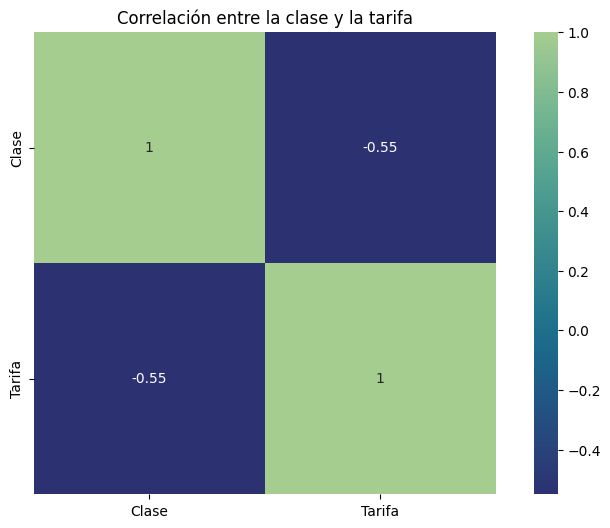

In [226]:
# Correlación entre la clase y la tarifa pagada
corr = df[['Pclass','Fare']].corr()
plt.figure(figsize=(10,6))
map = sns.heatmap(corr, annot=True, square=True, cmap='crest_r')
map.set_title('Correlación entre la clase y la tarifa')
map.set_xticklabels(('Clase','Tarifa'))
map.set_yticklabels(('Clase','Tarifa'));

Una correlación de -0.55 indica sí puede existir una correlación negativa moderada, es decir que mientras una variable disminuye (en este caso el número de la clase), la otra aumenta (en este caso la tarifa).

Hay que tener en cuenta que la clase numérica no corresponde con la clase social. Es decir, la clase numérica 1 (la más baja) corresponde a la primera clase, que socialmente es la más alta. Esto es necesario tenerlo en cuenta para la interpretación de la correlación negativa.

* Número de pasajeros embarcados (columna `Embarked`).


In [180]:
puerto = df['Embarked'].value_counts().reset_index()
fig = px.bar(puerto, x='Embarked',y='count', labels={'Embarked':'Puerto','count':'Cantidad de pasajeros'},
       width=600, title= 'Cantidad de pasajeros embarcados en cada puerto')

fig.update_xaxes(tickvals=['S', 'C', 'Q'], 
             ticktext=['Southampton', 'Cherbourg', 'Queenstown'])
fig.show()


* Ver la distribución de sexos en las personas embarcadas.

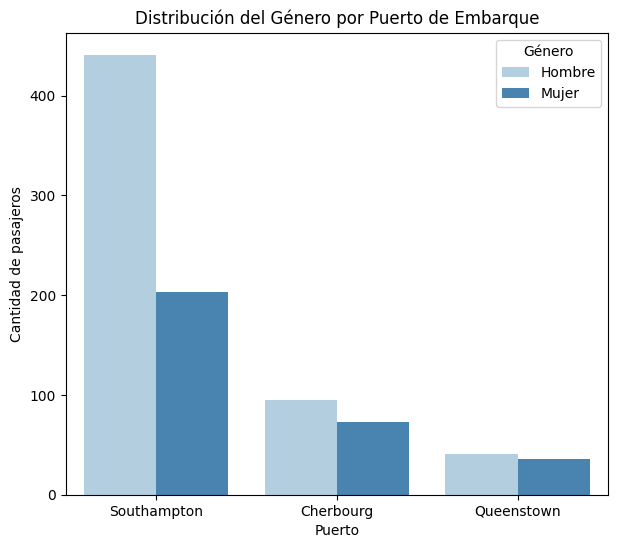

In [151]:
plt.figure(figsize=(7, 6)) 
sns.countplot(x='Embarked', hue='Sex', data=df, palette='Blues')
plt.title('Distribución del Género por Puerto de Embarque')
plt.xlabel('Puerto')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(ticks=['S','C','Q'], labels=['Southampton', 'Cherbourg', 'Queenstown'])
plt.legend(title='Género', labels=['Hombre', 'Mujer'])
plt.show()

* Distribución de supervivientes por género

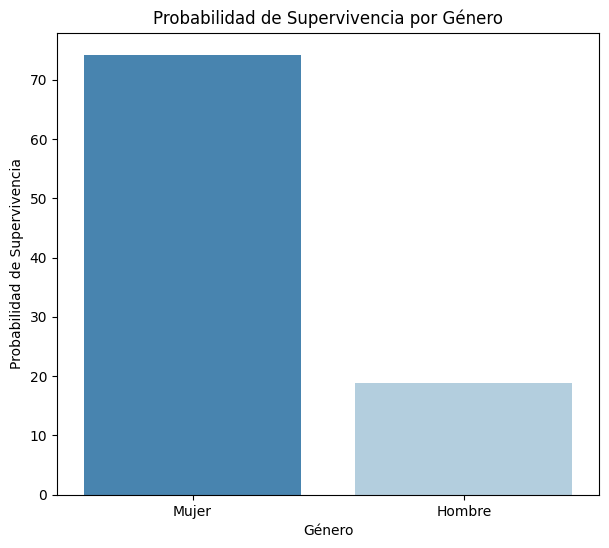

In [152]:
# Total de pasajeros por grupo de edad
total_genero = df.groupby('Sex', observed=False)['Survived'].count()

# Total de supervivientes por grupo de edad
supervivientes_genero = df.groupby('Sex', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_genero = (supervivientes_genero / total_genero)*100

plt.figure(figsize=(7,6))
sns.barplot(x=probabilidad_genero.index, y=probabilidad_genero.values, palette='Blues_r',
            hue = probabilidad_genero.index, legend= False)
plt.title("Probabilidad de Supervivencia por Género")
plt.xlabel("Género")
plt.ylabel("Probabilidad de Supervivencia")
plt.xticks(ticks=['female','male'], labels=['Mujer', 'Hombre'])
plt.show()

In [153]:
#Probabilidad de supervivencia por género:
round(probabilidad_genero,1)

Sex
female    74.2
male      18.9
Name: Survived, dtype: float64

* Cantidad de pasajeros por clase

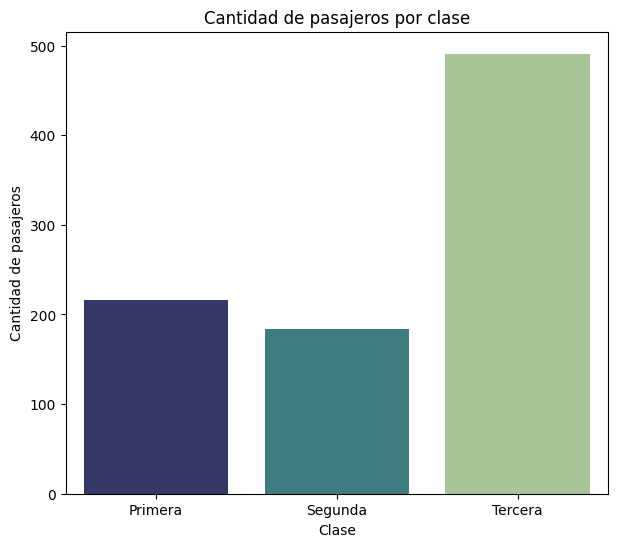

In [259]:
clases = df['Pclass'].value_counts().reset_index()
plt.figure(figsize=(7,6))
sns.barplot(data=clases, x ='Pclass', y='count', palette= 'crest_r',
            hue = 'Pclass',
            legend = False)
plt.title('Cantidad de pasajeros por clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(ticks=['1','2','3'], labels=['Primera', 'Segunda', 'Tercera'])
plt.show()

* Distribución de supervivientes por clase


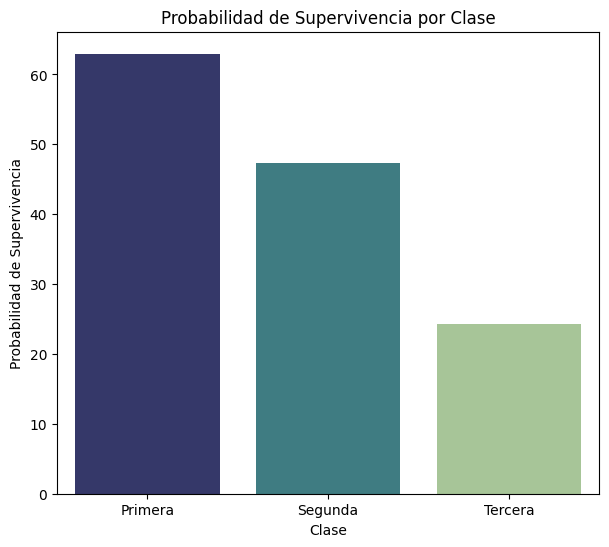

In [155]:
# Total de pasajeros por grupo de edad
total_por_clase = df.groupby('Pclass', observed=False)['Survived'].count()

# Total de supervivientes por grupo de edad
supervivientes_por_clase = df.groupby('Pclass', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_clase = (supervivientes_por_clase / total_por_clase)*100
plt.figure(figsize=(7,6))
sns.barplot(x=probabilidad_clase.index, y=probabilidad_clase.values, palette='crest_r',
            hue = probabilidad_clase.index, legend= False)
plt.title("Probabilidad de Supervivencia por Clase")
plt.xlabel("Clase")
plt.ylabel("Probabilidad de Supervivencia")
plt.xticks(ticks=['1','2','3'], labels=['Primera', 'Segunda', 'Tercera'])
plt.show()


* Tratamiento de la columna 'Cabin':

In [ ]:
# como predecir el camarote es muy complejo, intentaremos imputar sólo la letra de la cubierta ('Deck')
def extraer_deck(cabina):
    if pd.isna(cabina):
        return np.nan
    return cabina[0]
df['Deck'] = df['Cabin'].apply(extraer_deck)


In [268]:
#Porcentaje de valores de Deck conocidos por clase:
deck_clases = df.groupby('Pclass')['Deck'].count()
(deck_clases / total_por_clase)*100


Pclass
1    81.481481
2     8.695652
3     2.443992
dtype: float64

Deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64


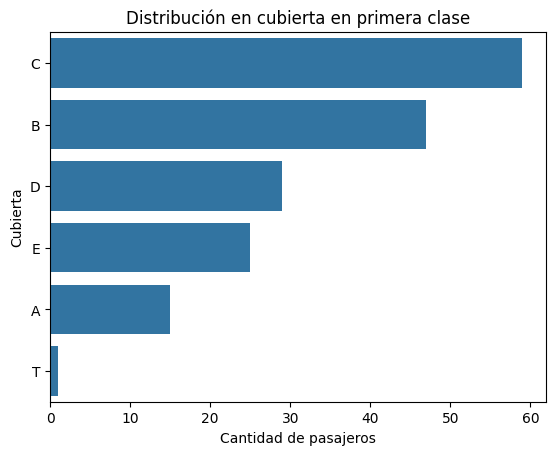

In [307]:
#Es fiable analizar la distribución por cabina de la primera clase que es de la que más información se tiene.
df_primera = df[df['Pclass']==1]
print(df['Deck'].value_counts())

sns.barplot(data =df_primera['Deck'].value_counts().reset_index(), y= 'Deck', x='count')
plt.title("Distribución en cubierta en primera clase")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Cubierta")
plt.show();

Se observa que aunque existen 8 cubiertas posibles, la mayoría de los pasajeros de primera clase tenían su camarote en las cubiertas: C, B, D, E y A.
Sería interesante conocer la ubicación de dichas cubiertas dentro del barco para entender cómo pudo influir este hecho en el acceso a los barcos salvavidas

* Comparación de la distribución por edad entre el dataset original y imputado por KNN:

In [156]:
# Se crea una nueva columna con los rangos de edades elegidos para ambos dataframe.
bins = [0, 15, 30, 45, 60, 80]
labels = ['0-15', '16-30', '31-45', '46-60','61-80']

#Se añade la nueva columna de rangos de edad al dataset original y al corregido.
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
datos['AgeGroup'] = pd.cut(datos['Age'], bins=bins, labels=labels, right=False)


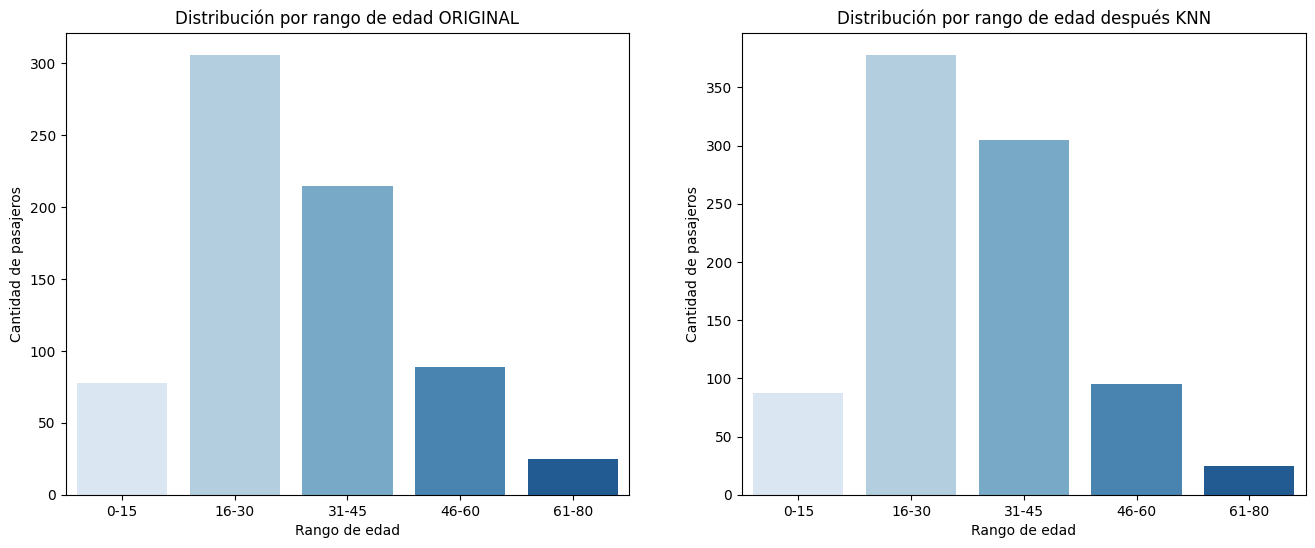

In [157]:
#Representación gráfica de la distribución de los pasajeros por rango de edad antes y después de la corrección:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(datos['AgeGroup'].value_counts().reset_index(), x='AgeGroup', 
            y = 'count', palette= 'Blues',
            hue = 'AgeGroup', ax=axes[0])
axes[0].set_title('Distribución por rango de edad ORIGINAL')
axes[0].set_xlabel('Rango de edad')
axes[0].set_ylabel('Cantidad de pasajeros')

sns.barplot(df['AgeGroup'].value_counts().reset_index(), x='AgeGroup', 
            y = 'count', palette= 'Blues',
            hue = 'AgeGroup', ax=axes[1])
axes[1].set_title('Distribución por rango de edad después KNN')
axes[1].set_xlabel('Rango de edad')
axes[1].set_ylabel('Cantidad de pasajeros');


* Comparación probabilidad de supervivencia por edad entre Original y KNN:

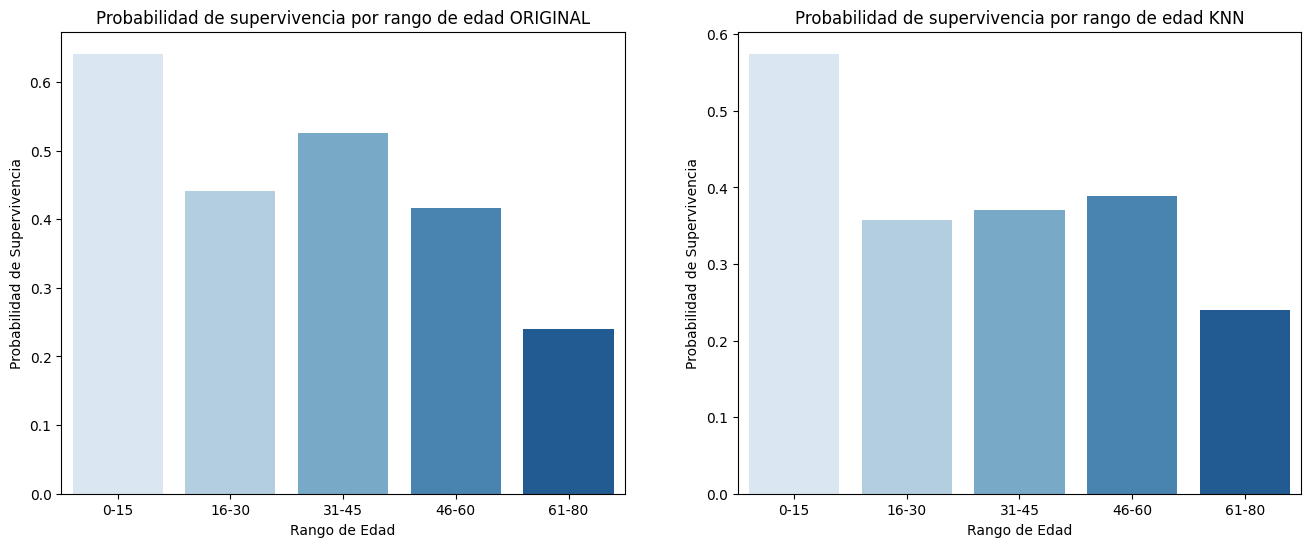

In [158]:
# Total de pasajeros por grupo de edad
total_por_edad_c= df.groupby('AgeGroup', observed=False)['Survived'].count()
total_por_edad_sc= datos.groupby('AgeGroup', observed=False)['Survived'].count()
# Total de supervivientes por grupo de edad
supervivientes_por_edad_c = df.groupby('AgeGroup', observed=False)['Survived'].sum()
supervivientes_por_edad_sc = df.groupby('AgeGroup', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_edad_c = supervivientes_por_edad_c / total_por_edad_c
probabilidad_edad_sc = supervivientes_por_edad_sc / total_por_edad_sc

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(x=probabilidad_edad_sc.index, y=probabilidad_edad_sc.values, palette = 'Blues',
            hue = probabilidad_edad_sc.index, ax= axes[0])
axes[0].set_title("Probabilidad de supervivencia por rango de edad ORIGINAL")
axes[0].set_xlabel("Rango de Edad")
axes[0].set_ylabel("Probabilidad de Supervivencia")

sns.barplot(x=probabilidad_edad_c.index, y=probabilidad_edad_c.values, palette = 'Blues',
            hue = probabilidad_edad_c.index, ax= axes[1])
axes[1].set_title("Probabilidad de supervivencia por rango de edad KNN")
axes[1].set_xlabel("Rango de Edad")
axes[1].set_ylabel("Probabilidad de Supervivencia");